<a href="https://colab.research.google.com/github/AlbertFlorinus/mnistcnn/blob/Colab_setup/alnet3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.ndimage import rotate
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, Adadelta
from keras.losses import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, CSVLogger
from cv2 import cv2

In [ ]:
# gathering the mnist-dataset, train is used for training,
# test is used to predict images previously unseen,
# we do this to ensure overfitting has not occurred,
# y are labels to X which are the images

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
# reshaping for keras compatibility
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)


In [ ]:
# changing datatype from uint8 to float32,
# this is to allow for normalizising the pixel value,
# between 0 and 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing pixels
X_train/=255
X_test/=255


In [ ]:
# one-hot-encoding the outputs, or in simpler terms,
# storing the outputs as a vector of 1x10
number_of_classes = 10
Y_train = np_utils.to_categorical(Y_train, number_of_classes)
Y_test = np_utils.to_categorical(Y_test, number_of_classes)


In [ ]:
print(Y_train.shape, Y_test.shape)

In [ ]:
model = Sequential()
# Val loss: 0.0234
# Val acc:  0.9960

In [ ]:
# each convolutional/conv layer distorts the input arrays
# each model.add creates a new layer in the network
# adding a spatial convolutional/conv layer and 
# declaring input shape required for the img array
# input shape value only needed for first conv
# 32 for the amount of filters and thus also feature maps outputed,
# (3,3) for filter size, default stride is 1

#model.add(Conv2D(16, (20,20), strides = 2, activation="relu", input_shape=(112,112,1), padding="same"))
#model.add(Conv2D(16, (10,10), strides = 2, activation="relu", padding="same"))

model.add(Conv2D(32, (3,3), activation="relu", input_shape = (28,28,1), padding="same" ) )
# adding a batchnormalization layer to reduce a batchs covariant shift,
# normalizing the images to execute more effectively,
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), activation="relu"))
model.add(BatchNormalization())

# adding conv layer with 5x5 filter and a stride of 2 instead of max pooling,
# downsampling image but retaining import data for classification.
model.add(Conv2D(32, (5,5), strides=2, padding="same",activation="relu"))
model.add(BatchNormalization())

# using dropout with a rate 0f 0.4, this randomly "drops",
# 40% of the nodes to a output value of 0 each iteration, which helps prevent overfitting
model.add(Dropout(0.4))

# raise amount from 32 to 64
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())


model.add(Conv2D(64, (5,5), strides=2, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# flattening the input to a 1d array,
# flattening the pixel data of 64 4x4 arrays
# to a 1d array containing 1024 pixel values,
# not 1024 pixels of the original image but of the,
# outputs from the convolutional neural network
# this ends the spatial/convolutional part of the network
model.add(Flatten())

# adding a fully connected layer of 128 neurons
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Final layer of 10 neurons with a softmax activation,
# this outputs a prediction (number with highest activation value)
model.add(Dense(number_of_classes, activation="softmax"))


In [ ]:
# Declaring loss function and optimizer,
# Adam is an enhancement of SGD.
# Accuracy metric for us to get results for evaluating the model 
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
# Number of images to iterate simultaneously before each weight update
batchsize = 64

In [ ]:
X_val = X_test[9000:]
Y_val = Y_test[9000:]

In [ ]:
X_test = X_test[:9000]
Y_test = Y_test[:9000]


In [ ]:
print(X_test.shape, Y_test.shape)

In [ ]:
# Augmentning training data for better generalisation,
# and prevent overfitting
gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.15)
train_generator = gen.flow(X_train, Y_train, batch_size=batchsize)

In [ ]:
testing_generator = gen.flow(X_test, Y_test, batch_size=batchsize)

In [ ]:
# Reducing learning rate to 95% of the last epoch,
# speeding up convergence by keeping weight updates smaller as the model,
# approaches convergence.
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [ ]:
# Log file for tracking information about the learning process and its metrics
csv_logger = CSVLogger("training_test.log", append=True, separator=";")

In [ ]:
# starting training, validation_data is mnist data not trained on,
# to ensure us we arent overfitting to the training set but actually generalising
history = model.fit(train_generator,steps_per_epoch=X_train.shape[0]//batchsize, epochs=10, 
                  validation_data=testing_generator, callbacks=[annealer, csv_logger], verbose=1)


Epoch 1/10
937/937 [==============================] - 69s 24ms/step - loss: 0.8028 - accuracy: 0.7600 - val_loss: 0.0728 - val_accuracy: 0.9747
Epoch 2/10
937/937 [==============================] - 21s 23ms/step - loss: 0.1241 - accuracy: 0.9623 - val_loss: 0.0691 - val_accuracy: 0.9773
Epoch 3/10
937/937 [==============================] - 21s 23ms/step - loss: 0.0927 - accuracy: 0.9713 - val_loss: 0.0454 - val_accuracy: 0.9858
Epoch 4/10
937/937 [==============================] - 21s 23ms/step - loss: 0.0737 - accuracy: 0.9774 - val_loss: 0.0379 - val_accuracy: 0.9882
Epoch 5/10
937/937 [==============================] - 21s 23ms/step - loss: 0.0656 - accuracy: 0.9807 - val_loss: 0.0364 - val_accuracy: 0.9880
Epoch 6/10
937/937 [==============================] - 21s 23ms/step - loss: 0.0606 - accuracy: 0.9820 - val_loss: 0.0304 - val_accuracy: 0.9911
Epoch 7/10
937/937 [==============================] - 22s 23ms/step - loss: 0.0549 - accuracy: 0.9837 - val_loss: 0.0319 - val_accuracy:

In [ ]:
model.save("ALnet-3.0.h5")

In [ ]:
score = model.evaluate(x=X_val, y=Y_val, verbose=1)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

In [ ]:
model = keras.models.load_model("/content/ALnet-3.0.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/digits2.zip -d /content/digits

In [ ]:
def preprocessor(img):
  # this resize the image to square 112x112 shape with interpolating to center the digit
  gray = img
  dilated_gray = cv2.dilate(gray, np.ones((7,7), np.uint8))
  bg_gray = cv2.medianBlur(dilated_gray, 21)
  diff_gray = 255-cv2.absdiff(gray, bg_gray)
  norm_gray = diff_gray.copy()
  norm_img = np.zeros((320,240))
  norm_gray = cv2.normalize(diff_gray, norm_img, alpha = 0, beta = 255, norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
  test_img = diff_gray - norm_gray  
  test_img2 = cv2.dilate(test_img, np.ones((5,5)))

  ret2,gray3 = cv2.threshold(test_img2,0,255,cv2.THRESH_OTSU)
  gray3 = cv2.resize(gray3, (28,28), interpolation = cv2.INTER_AREA)
  return gray3, gray3.copy()

In [ ]:
def into_alnet(img):
  img = img.reshape((1,28,28,1))
  img = img.astype('float32')
  img /= 255
  return img

In [ ]:
import os
cnet_in = []
usr_out = []
usr_orig = []
count = 0
for filename in os.listdir("/content/digits/digits"):
  if filename.endswith((".DS_Store")):
    pass
  elif count < 1:
    count += 1
  elif count < 120:

    img = cv2.imread("/content/digits/digits/" + filename, 0)
    prep, usr_img = preprocessor(img)
    prep = into_alnet(prep)
    cnet_in.append(prep)
    usr_orig.append(img)
    usr_out.append(usr_img)

    count += 1

In [ ]:
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


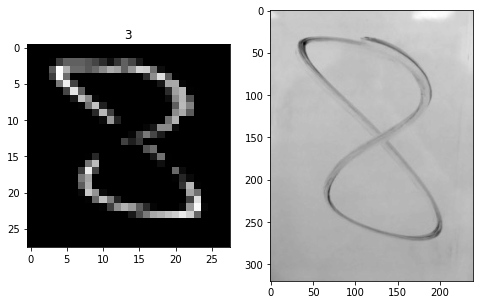

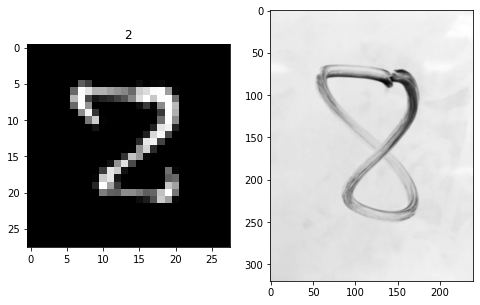

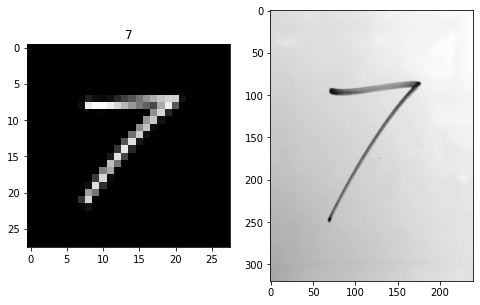

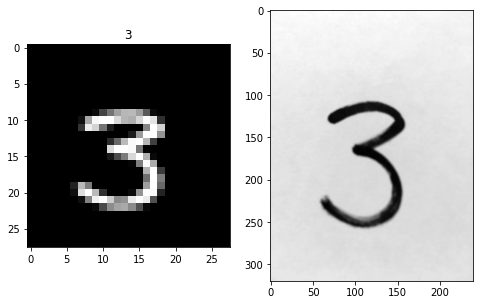

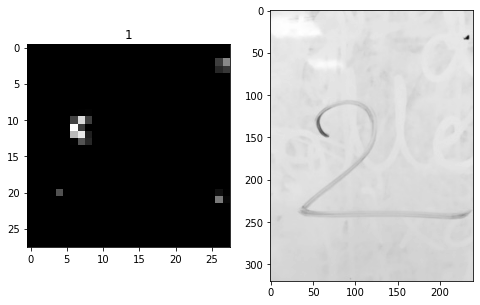

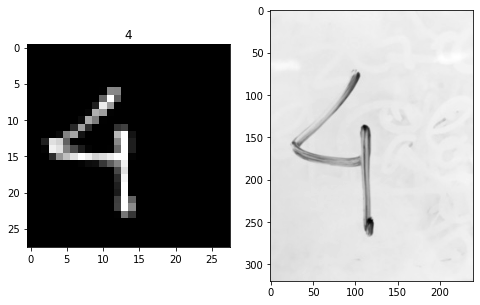

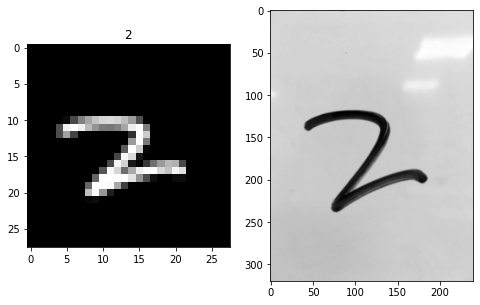

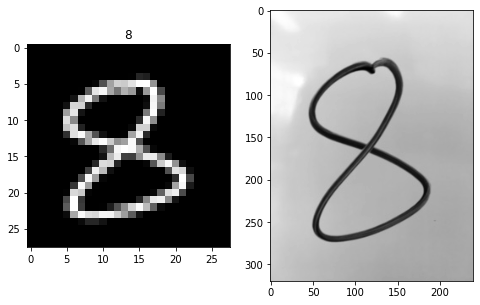

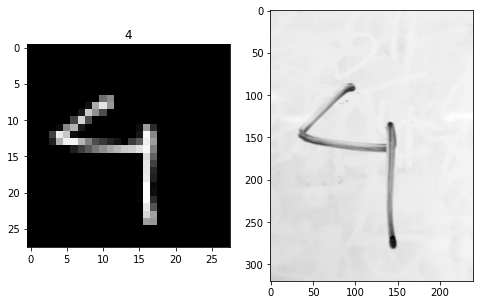

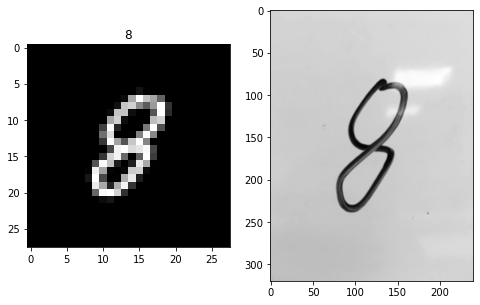

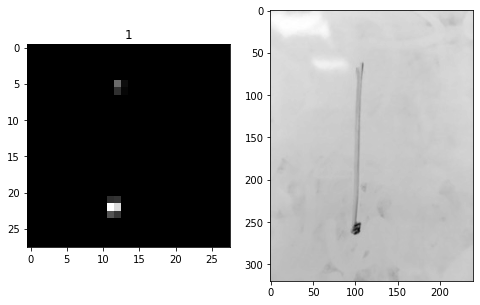

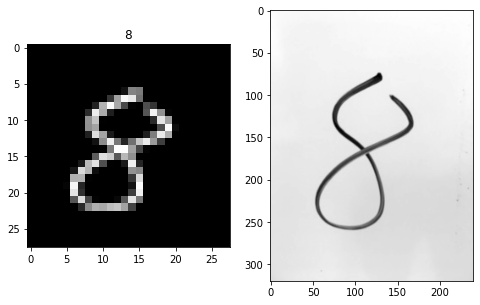

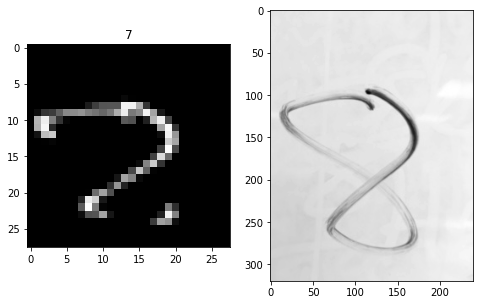

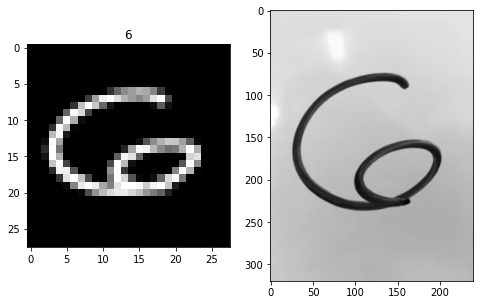

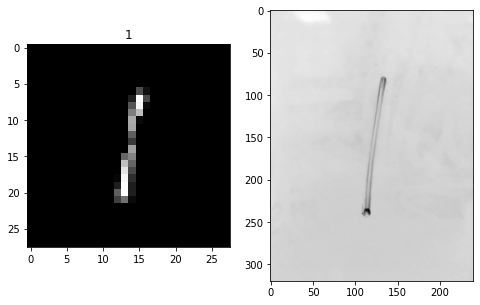

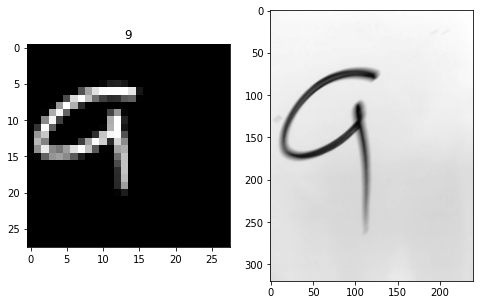

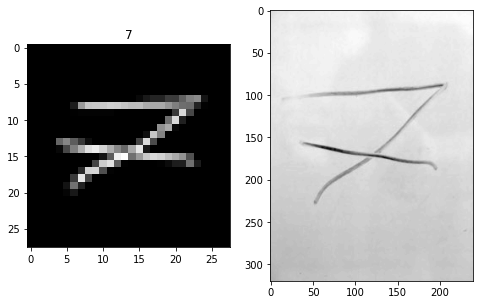

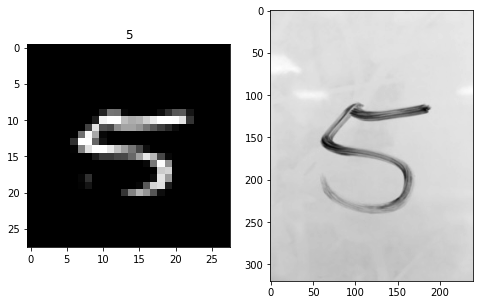

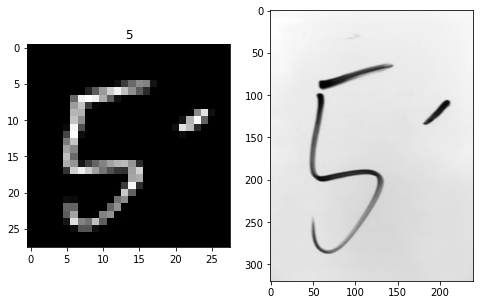

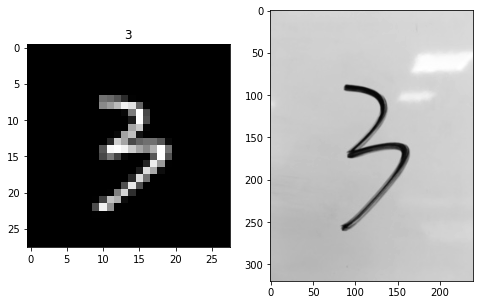

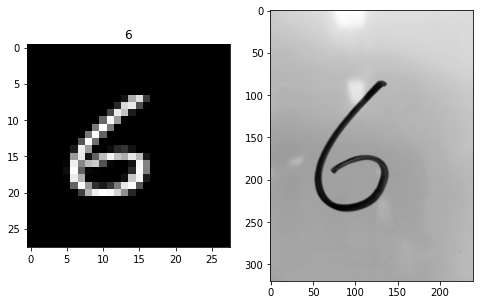

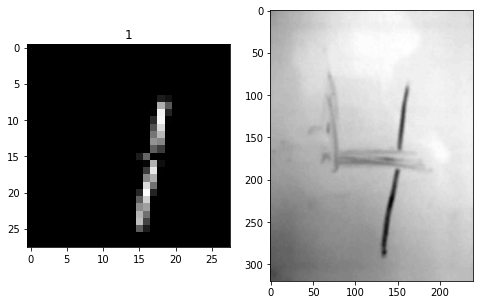

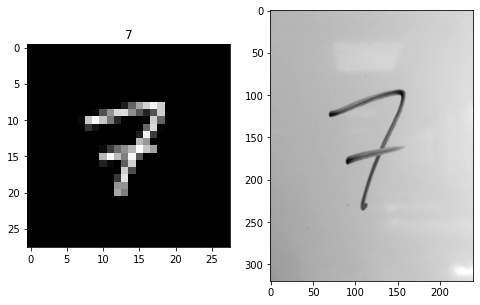

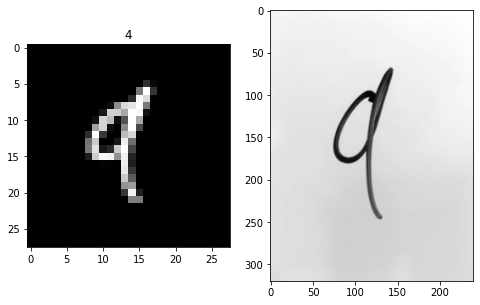

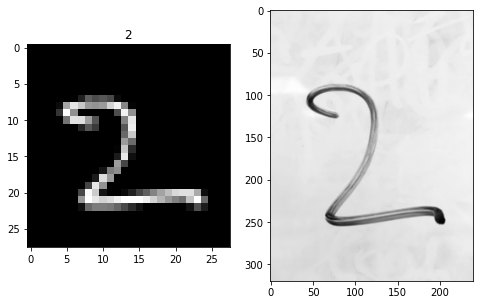

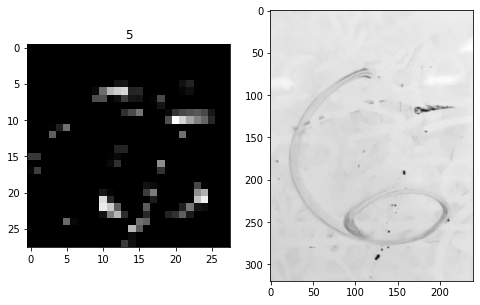

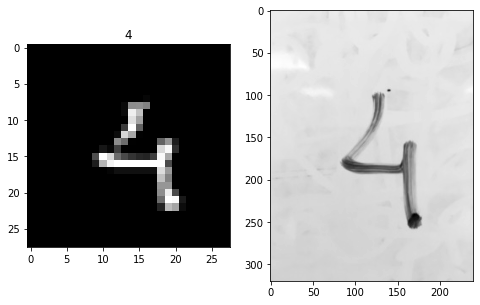

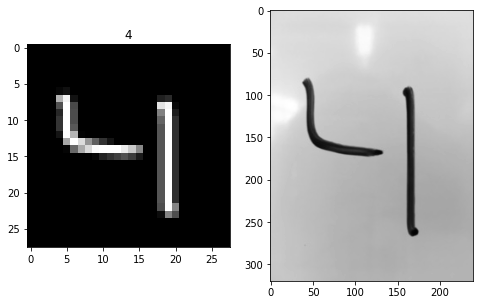

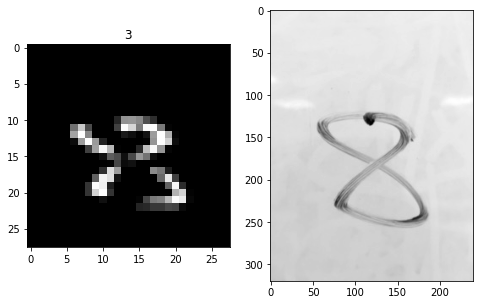

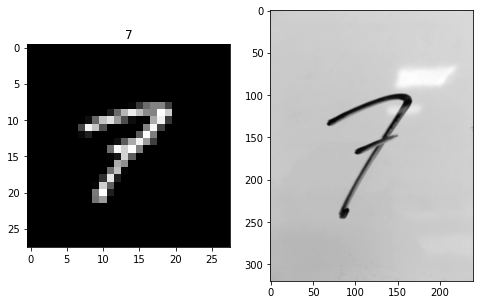

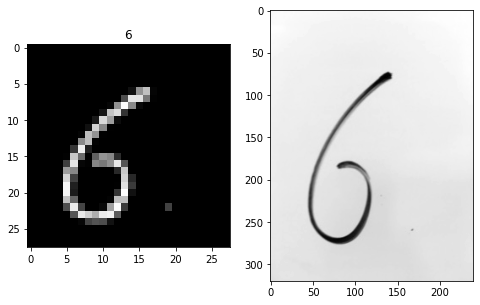

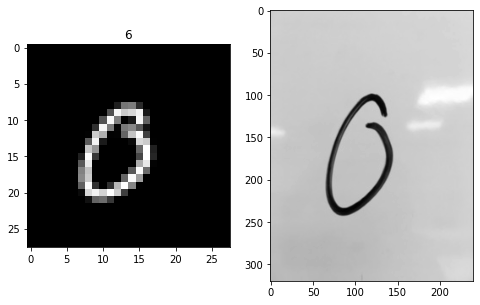

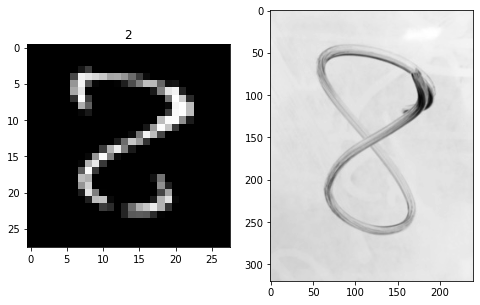

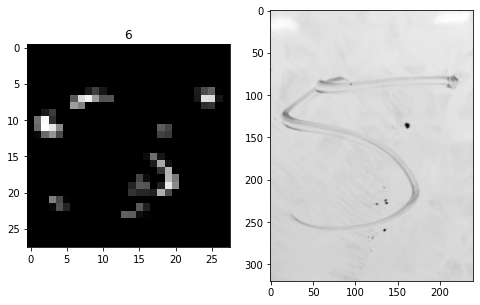

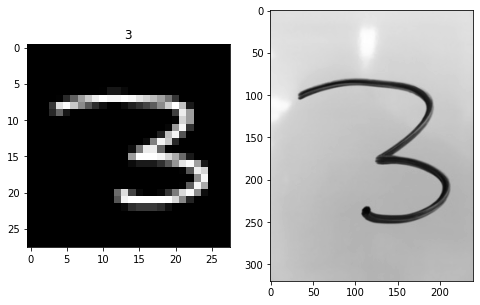

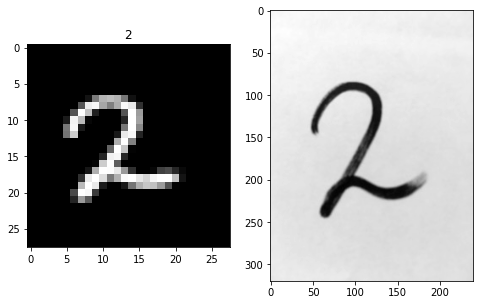

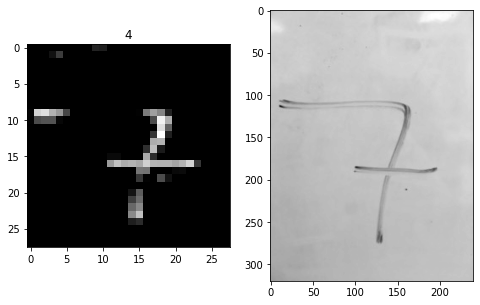

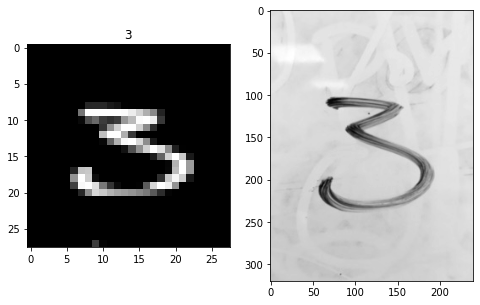

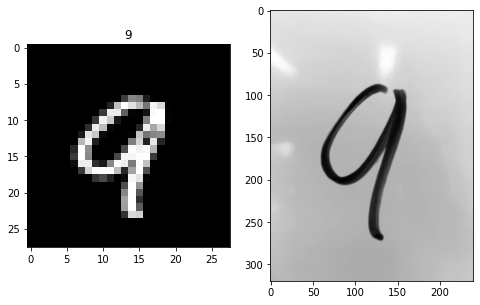

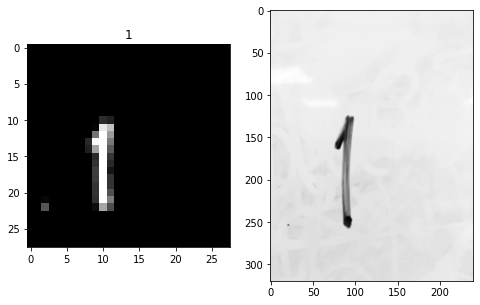

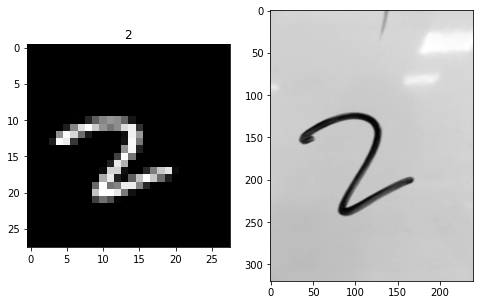

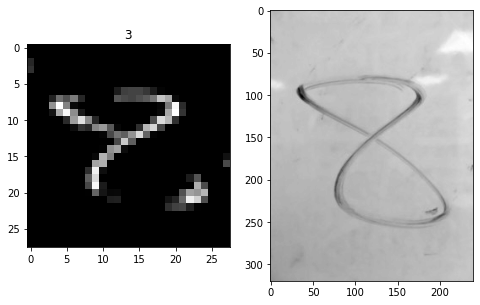

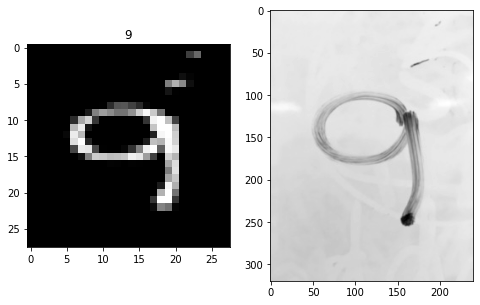

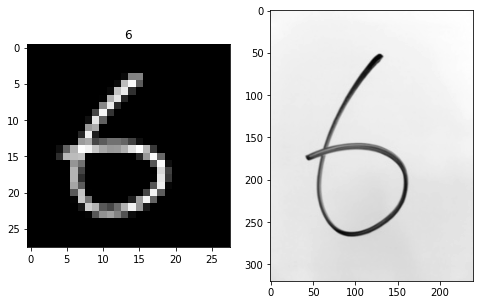

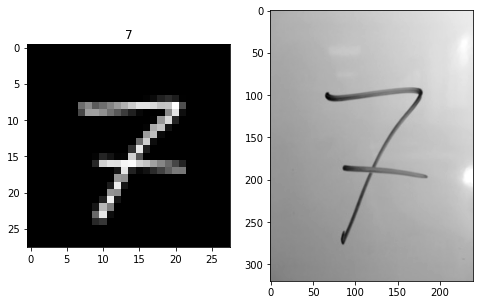

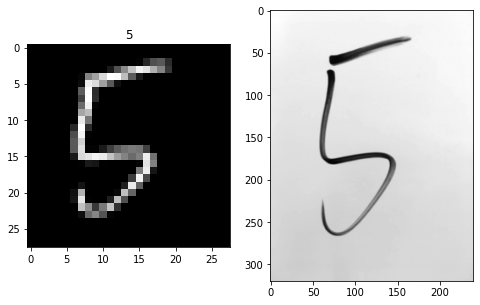

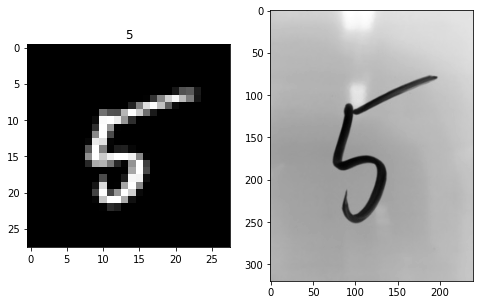

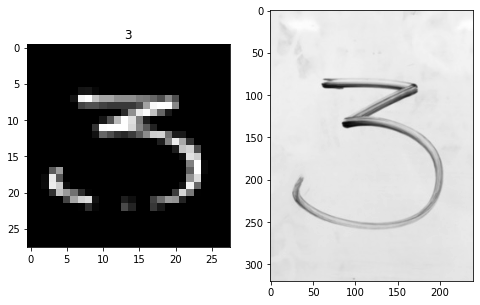

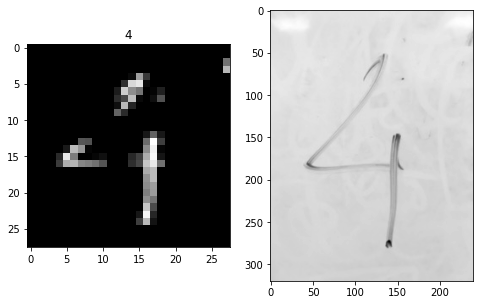

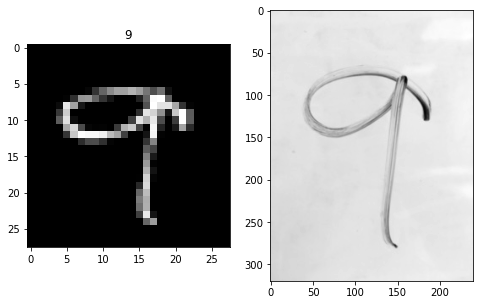

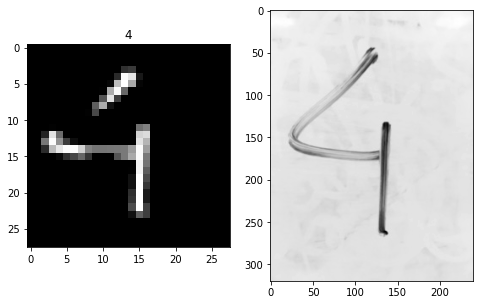

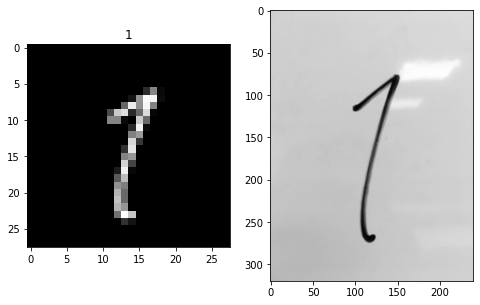

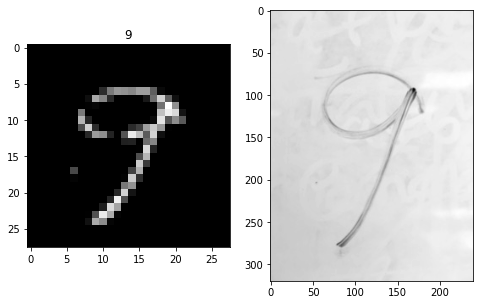

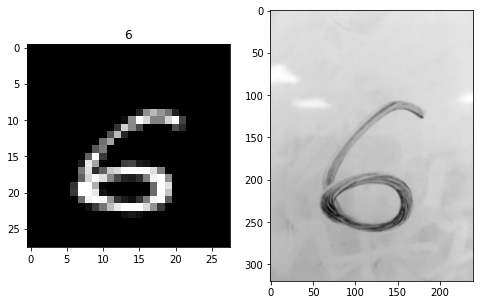

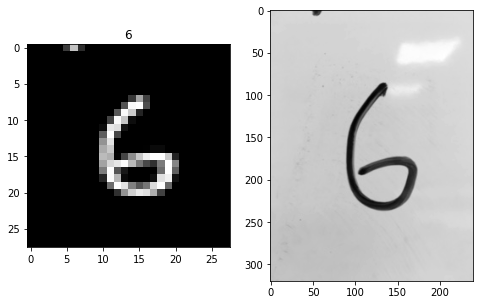

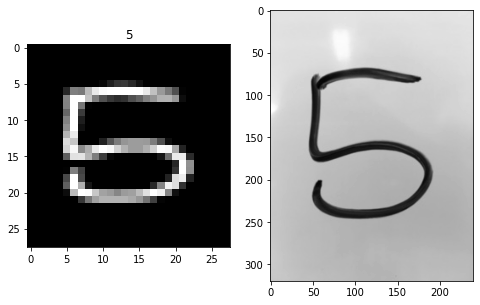

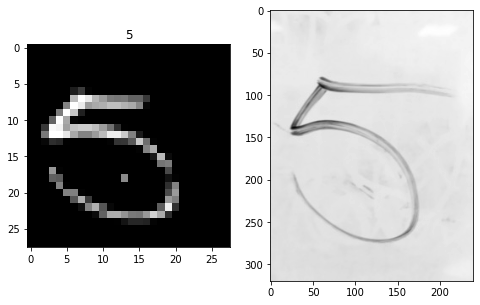

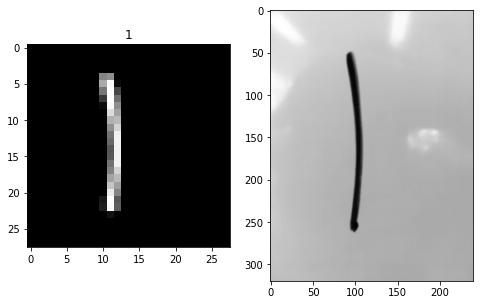

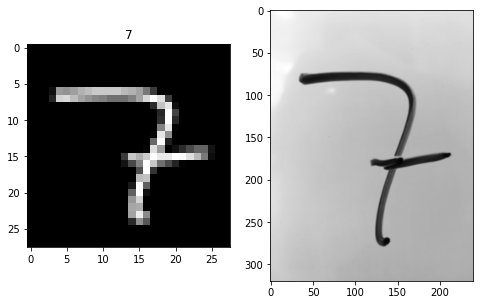

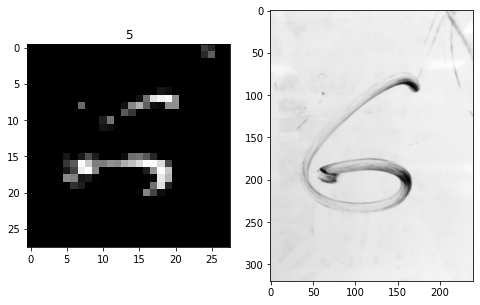

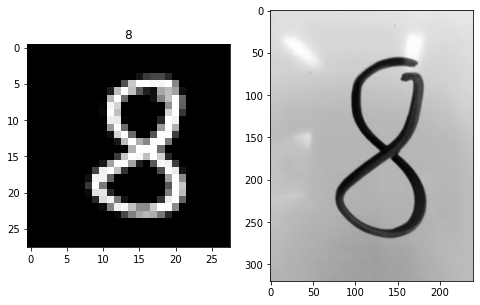

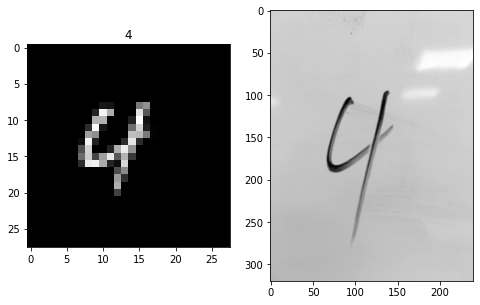

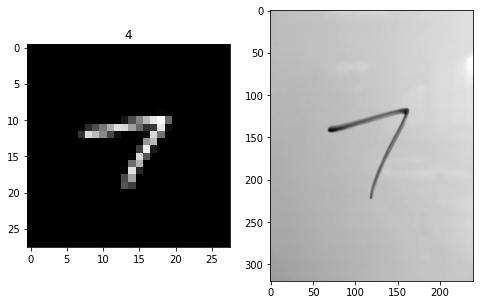

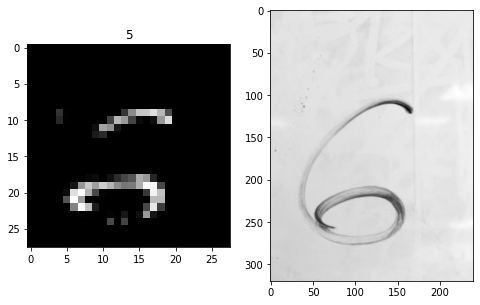

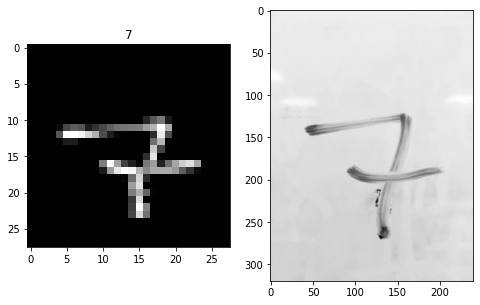

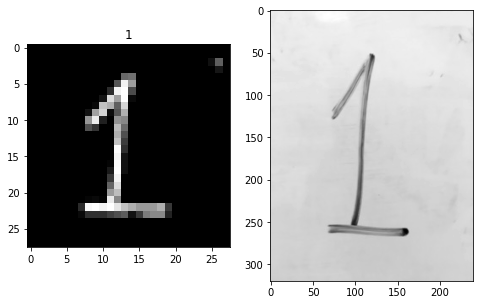

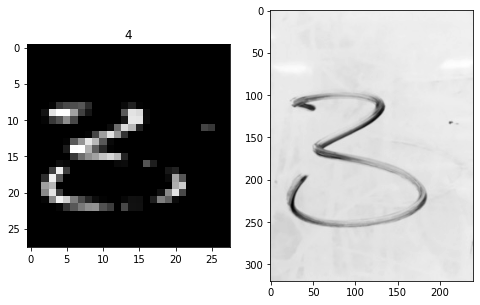

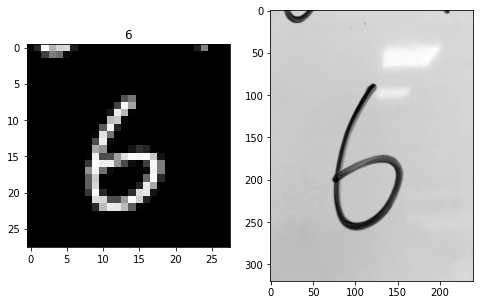

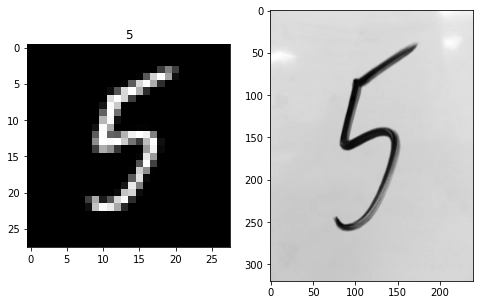

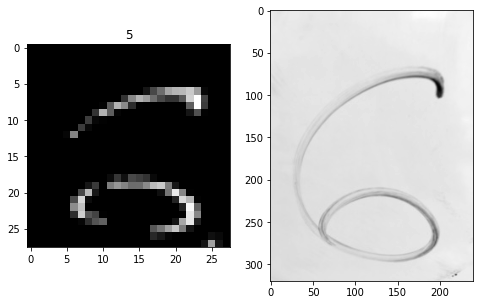

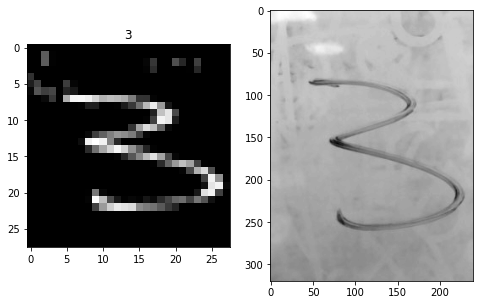

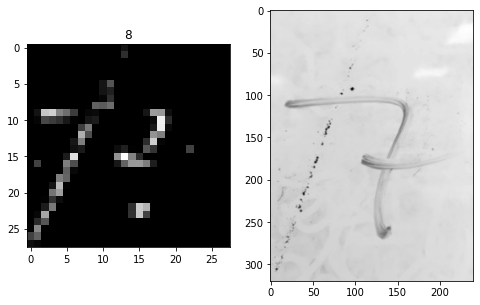

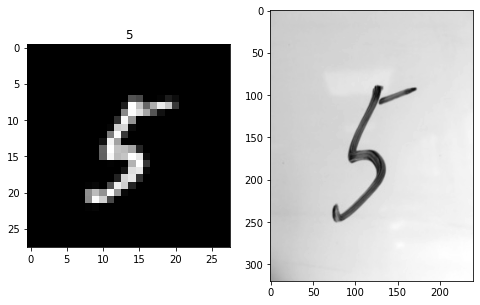

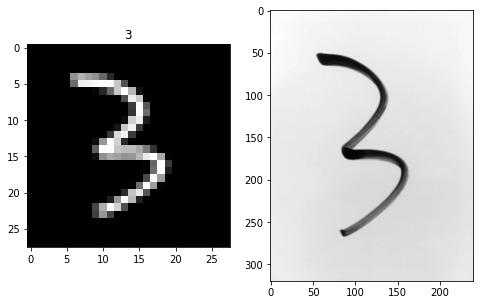

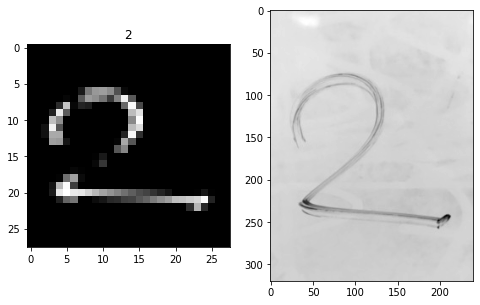

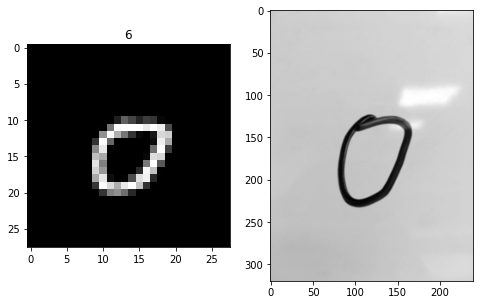

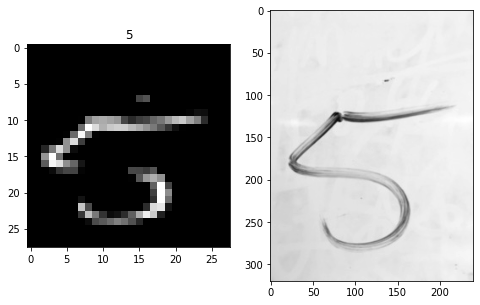

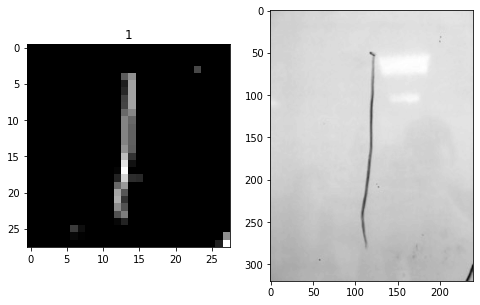

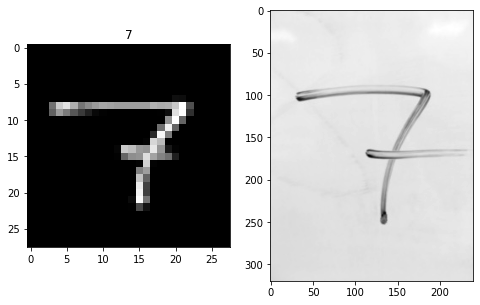

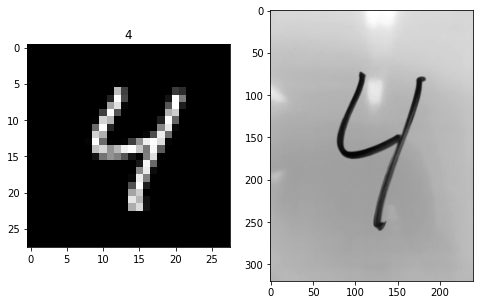

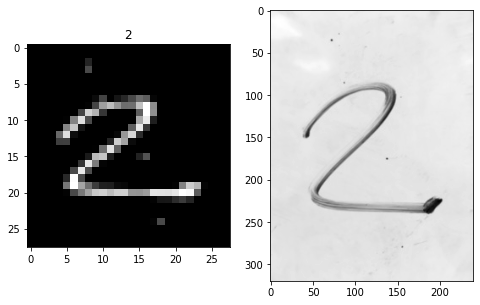

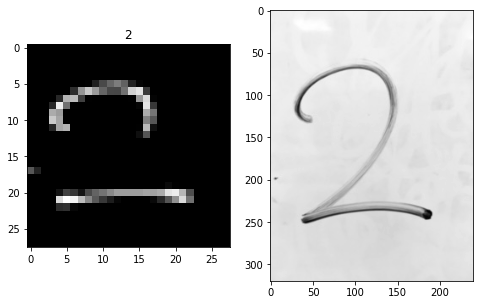

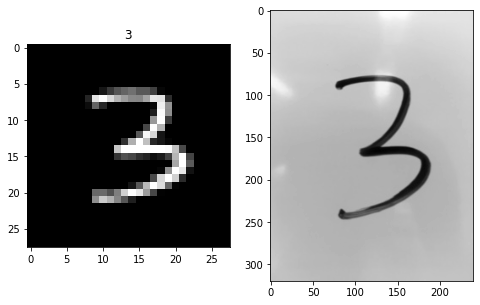

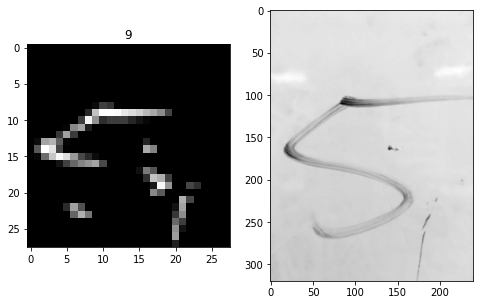

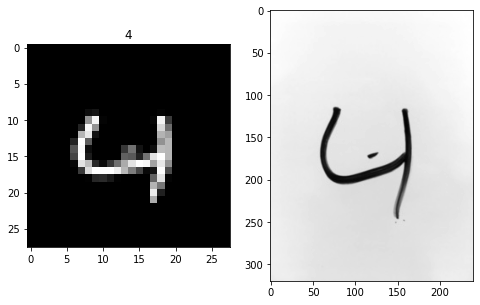

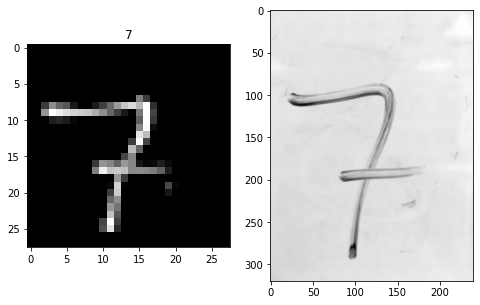

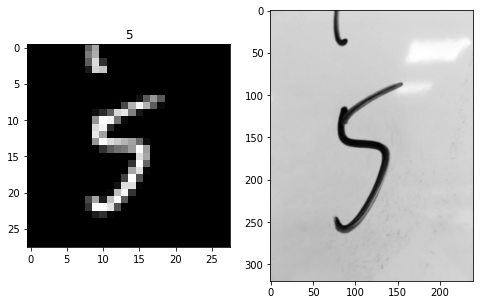

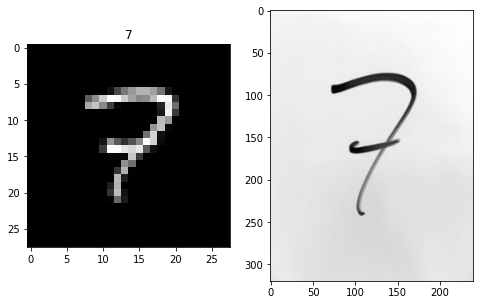

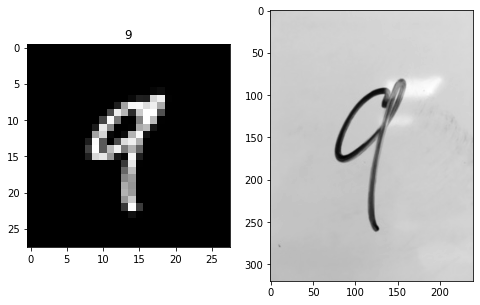

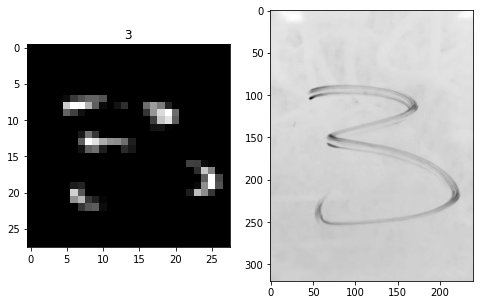

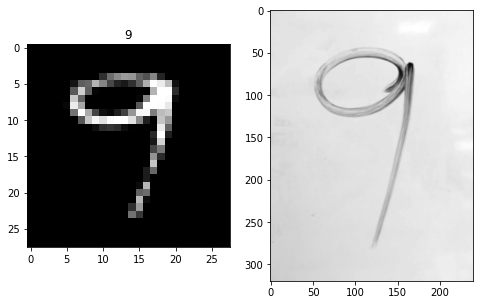

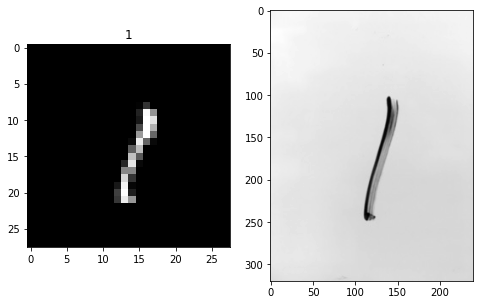

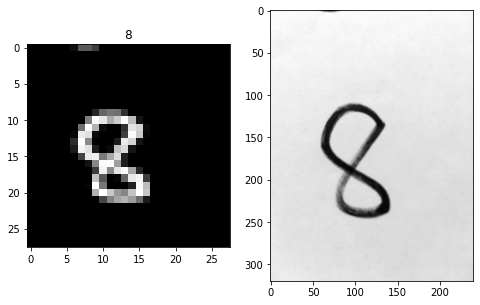

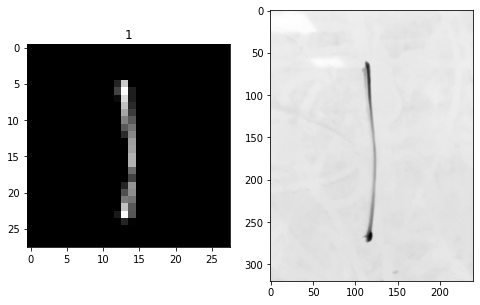

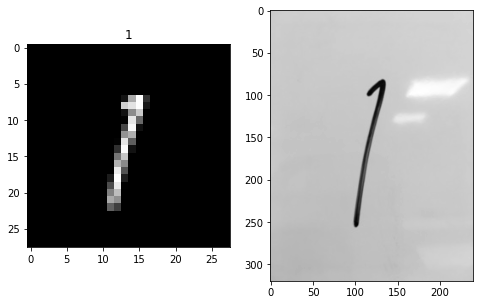

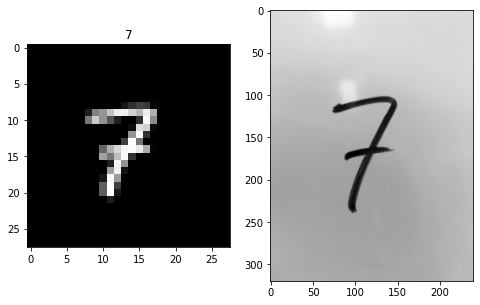

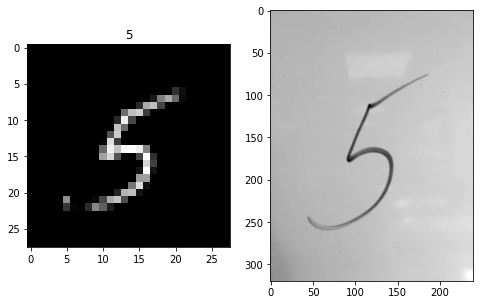

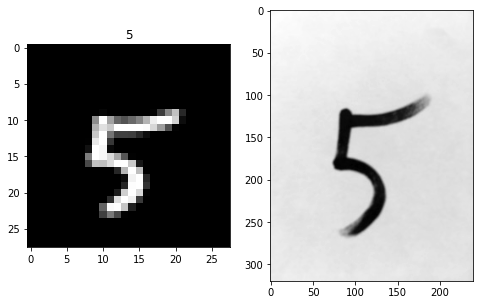

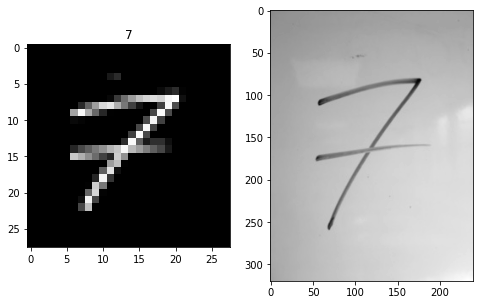

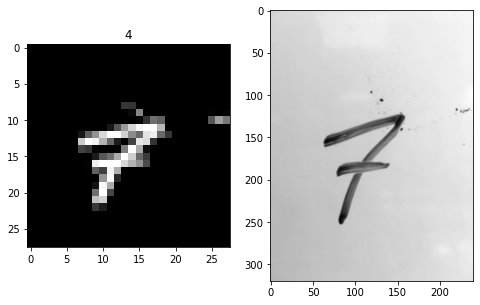

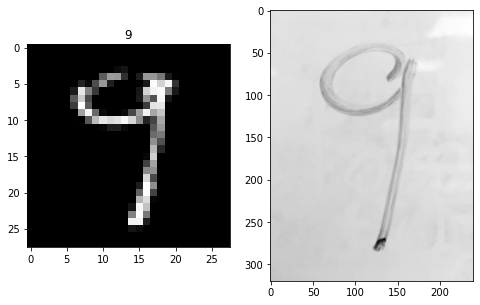

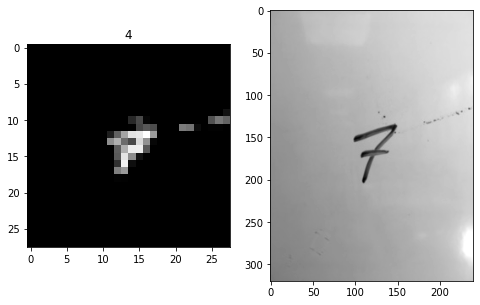

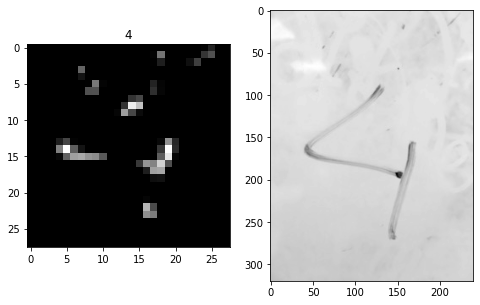

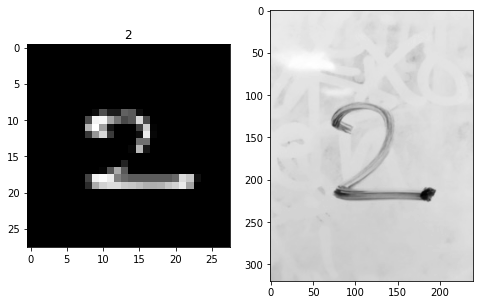

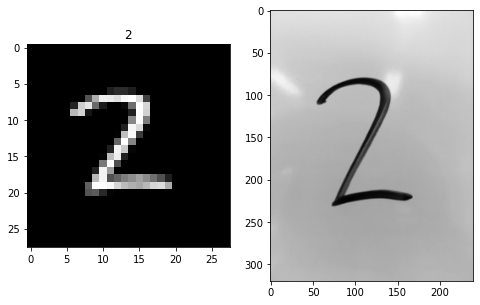

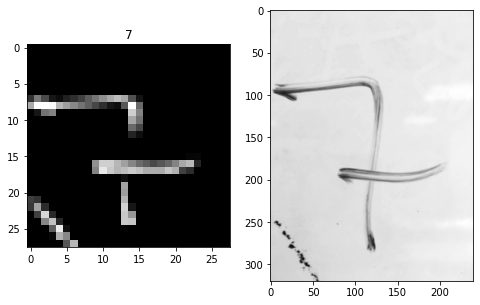

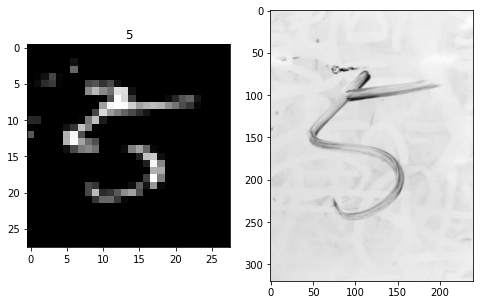

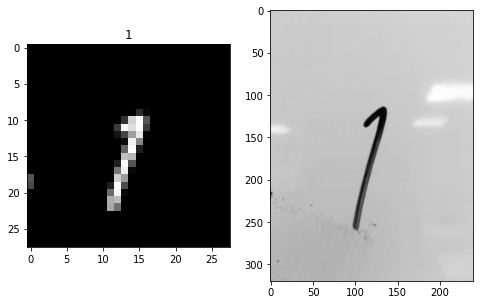

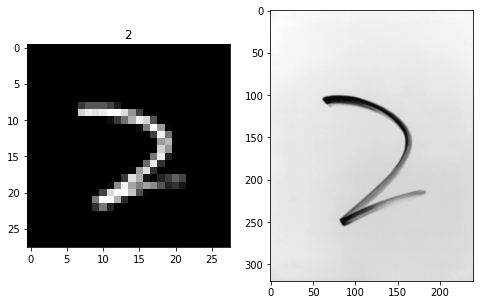

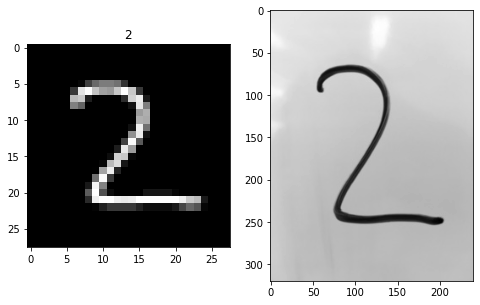

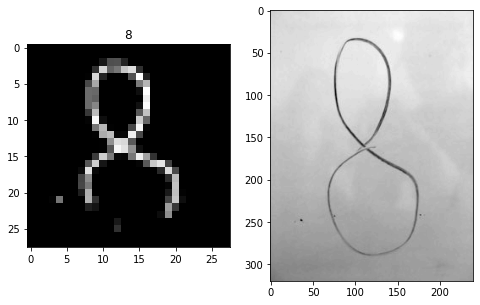

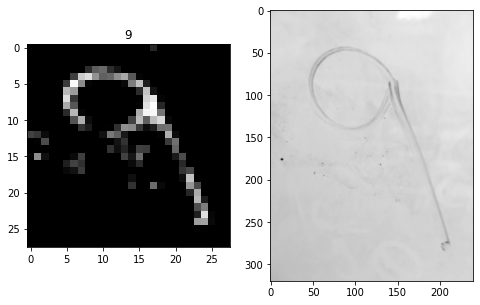

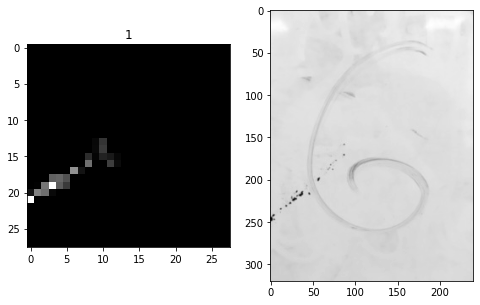

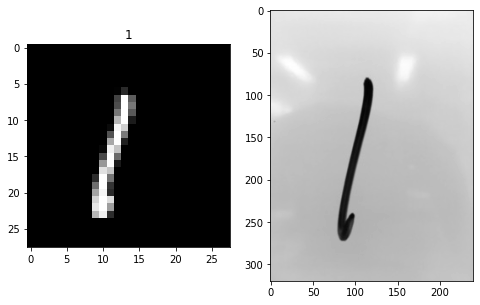

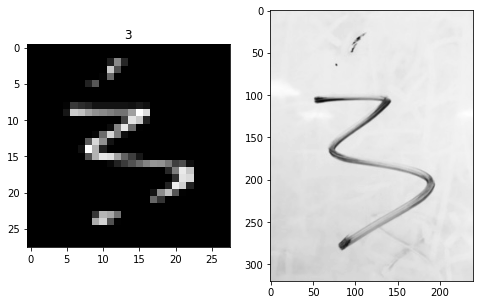

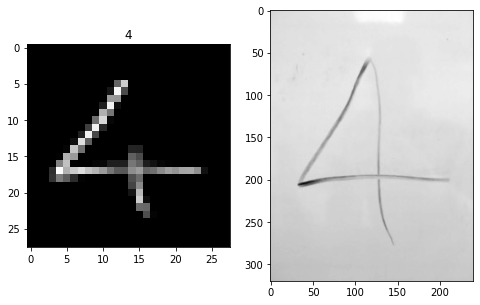

In [ ]:
count = 0

for i in cnet_in:
  fig = plt.figure(figsize=(8,8))
  plt.gray()
  prediction = model.predict(i)
  #print(prediction)
  x1 = np.argmax(prediction)

  fig.add_subplot(1,2,1).set_title(x1)
  plt.imshow(usr_out[count])

  fig.add_subplot(1,2,2)
  plt.imshow(usr_orig[count])
  #print(x1)
  count += 1
  